# Evaluating AIWC metrics between Cuda, OpenACC, OpenMP and OpenCL

We present an evaluation of the change in AIWC metrics between Cuda, OpenACC and OpenCL implementations of the same 2 algorithms.
OpenCL and Cuda codes are selected from the [Rodinia Benchmark Suite](https://github.com/BeauJoh/rodinia.git) which was chosen because it's original goal was as a comparison between languages on heterogenous computing architectures. Presently it boasts Cuda, OpenCL, OpenMP and OpenACC versions of several application codes.

cocl -- as part of [coriander](https://github.com/hughperkins/coriander.git) -- is used to perform the translation of Cuda to OpenCL codes, while [OpenARC](https://csmd.ornl.gov/project/openarc-open-accelerator-research-compiler/) is used for the OpenACC to OpenCL translation.
This project assumes OpenARC is setup in the codes directory -- for instance, `aiwc-for-the-masses/codes/OpenARC` -- see the [Section on OpenARC Usage and Setup](#openarc-usage-and-setup) for details.

In [2]:
%load_ext rpy2.ipython




## Set environment variables

In [3]:
%env COCL=/coriander/bin/bin/cocl
%env NVCC=/usr/local/cuda/bin/nvcc
%env OPENARC_ARCH=1 ACC_DEVICE_TYPE=RADEON

env: COCL=/coriander/bin/bin/cocl
env: NVCC=/usr/local/cuda/bin/nvcc
env: OPENARC_ARCH=1 ACC_DEVICE_TYPE=RADEON


## Results
This section generates and plots the results emphasising the difference in AIWC features spaces of Gaussian Elimination and Breadth-First-Search.

### Gaussian Elimination
The following code-block generates the AIWC feature spaces for the CUDA, OpenCL and OpenACC implementations, see the [Makefile](./Makefile) (specifically test_gaussian) for details.
Click [here](#Fan1) to jump to the analysis.

In [11]:
! rm -rf gaussian_results
! make clean
#if we are sporting an Nvidia runtime in docker then also run the direct cuda version.
#hint: docker run --runtime=nvidia -e NVIDIA_VISIBLE_DEVICES=1 -it --mount src=`pwd`,target=/workspace,type=bind -p 8888:8888 --net=host --cap-add=SYS_PTRACE --security-opt seccomp=unconfined beau/aiwc-for-the-masses
! if test -f "/usr/bin/nvidia-smi"; then make test_gaussian_cuda; fi
! make test_gaussian

rm -f *.ll *.o gaussian_cuda gaussian_opencl gaussian_hand_opencl myocyte_hand_opencl *.cl aiwc_* heartwall_cuda heartwall_opencl heartwall_hand_opencl backprop_opencl bfs_cuda bfs_opencl bfs_hand_opencl -r gaussian_openacc_version/cetus_output gaussian_openacc_version/bin
nvcc gaussian_cuda_version/gaussian.cu -o gaussian_cuda
echo "Running CUDA version..." && \
./gaussian_cuda ./data/gaussian_matrix4.txt && \
echo "Done."
Running CUDA version...
sizing info: 4x4 blocks, in a 1x1 grid
Matrix m is: 
    0.00     0.00     0.00     0.00 
    0.50     0.00     0.00     0.00 
    0.67     0.26     0.00     0.00 
   -0.00     0.15    -0.28     0.00 

Matrix a is: 
   -0.60    -0.50     0.70     0.30 
    0.00    -0.65    -0.05     0.55 
   -0.00     0.00    -0.75    -1.14 
    0.00    -0.00     0.00     0.50 

Array b is: 
-0.85 -0.25 0.87 -0.25 

The final solution is: 
0.70 0.00 -0.40 -0.50 


Time total (including memory transfers)	0.154291 sec
Time for CUDA kernels:	0.000086 sec
Done.
/

cp gaussian_opencl_version/gaussianElim_kernels.cl .
g++ gaussian_opencl_version/*.cpp -I./gaussian_opencl_version/ -lOpenCL -o gaussian_hand_opencl
gaussian_opencl_version/clutils.cpp: In function '_cl_context* cl_init(char)':
gaussian_opencl_version/clutils.cpp:224:63: warning: '_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)' is deprecated [-Wdeprecated-declarations]
                             CL_QUEUE_PROFILING_ENABLE, &status);
                                                               ^
In file included from gaussian_opencl_version/clutils.cpp:57:0:
/usr/include/CL/cl.h:1443:1: note: declared here
 clCreateCommandQueue(cl_context                     /* context */,
 ^~~~~~~~~~~~~~~~~~~~
gaussian_opencl_version/clutils.cpp:227:74: warning: '_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)' is deprecated [-Wdeprecated-declarations]
     commandQueueNoProf = clCreateCo


====> To compile the translated output file:
$ make

====> To run the compiled binary:
$ cd bin; gaussian_ACC

make[1]: Entering directory '/workspace/codes/gaussian_openacc_version'
mkdir -p ./bin
mkdir -p cetus_output
cd cetus_output; g++ -D_N_=512 -DOMP=0 -I/workspace/codes/OpenARC/openarcrt -D_OPENACC=201306 -D OPENARC_ARCH=1 -O3  -I/workspace/codes/OpenARC/openarcrt  -I ../ -o .././bin/gaussian_ACC gaussian.cpp  -L/workspace/codes/OpenARC/openarcrt -lopenaccrt_opencl -L/opt/AMDAPPSDK-3.0/lib/x86_64 -lOpenCL  -L/workspace/codes/OpenARC/openarcrt; cp openarc_kernel.cl .././bin; if [ -f "/workspace/codes/OpenARC/openarcrt/binBuilder_opencl" ]; then cp /workspace/codes/OpenARC/openarcrt/binBuilder_opencl .././bin; fi; cp /workspace/codes/OpenARC/openarcrt/Timer .././bin; cd ../
gaussian.cpp: In function 'void InitProblemOnce(char*)':
gaussian.cpp:265:7: warning: ignoring return value of 'int fscanf(FILE*, const char*, ...)', declared with attribute warn_unused_result [-Wunused-result

[INFO] Create openarc_kernel_TeslaP100-PCIE-12GB.ptx for device 0
[INFO] Max # of work-items in a work-group for device 0: 1024


make[1]: Leaving directory '/workspace/codes/gaussian_openmp_version'
rm -rf gaussian_results; mkdir -p gaussian_results; mkdir -p gaussian_results/cuda; mkdir -p gaussian_results/opencl; mkdir -p gaussian_results/openacc; mkdir -p gaussian_results/openmp && \
echo "Running Coriander/CUDA version..." && \
/oclgrind/bin/oclgrind --aiwc ./gaussian_opencl ./data/gaussian_matrix4.txt; mv aiwc_* gaussian_results/cuda && \
echo "Done." && \
echo "Running OpenCL version..." && \
/oclgrind/bin/oclgrind --aiwc ./gaussian_hand_opencl ./data/gaussian_matrix4.txt -p 0 -d 0; mv aiwc_* gaussian_results/opencl && \
echo "Done." && \
echo "Running OpenACC version..." && \
cd gaussian_openacc_version/bin; /oclgrind/bin/oclgrind --aiwc ./gaussian_ACC ../../data/gaussian_matrix4.txt ; mv aiwc_* ../../gaussian_results/openacc && \
cd ../.. && \
echo "Running OpenMP version..." 


# Architecture-Independent Workload Characterization of kernel: _Z4Fan2PfS_S_iii

## Compute

|Opcode              |       count|
|--------------------|-----------:|
|call                |          80|
|add                 |          76|
|getelementptr       |          72|
|trunc               |          72|
|bitcast             |          48|
|mul                 |          36|
|br                  |          32|
|icmp                |          30|
|sub                 |          24|
|load                |          24|
|sext                |          22|
|ret                 |          16|
|store               |           8|
|fsub                |           8|

unique opcodes required to cover 90% of dynamic instructions: call, add, getelementptr, trunc, bitcast, mul, br, icmp, sub, load

num unique opcodes required to cover 90% of dynamic instructions: 10

Total Instruction Count: 548

## Parallelism

### Utilization

Freedom to Reorder: 10.00

Resource Pressure: 2.00

### Thread-Le

Using Platform 0 	 Device No 0 
This Context Type Not Supported
: Success
	gaussianElim_kernels.cl
sizing info: fan1 4 global workitems in 4 sized workgroups, fan2 4x4 workitems 

# Architecture-Independent Workload Characterization of kernel: Fan1

## Compute

|Opcode              |       count|
|--------------------|-----------:|
|getelementptr       |          18|
|add                 |          14|
|call                |          12|
|mul                 |          10|
|sext                |           9|
|br                  |           7|
|load                |           6|
|sub                 |           4|
|ret                 |           4|
|icmp                |           4|
|trunc               |           4|
|store               |           3|
|fdiv                |           3|

unique opcodes required to cover 90% of dynamic instructions: getelementptr, add, call, mul, sext, br, load, sub, ret, icmp, trunc

num unique opcodes required to cover 90% of dynamic instructions:


# Architecture-Independent Workload Characterization of kernel: Fan2

## Compute

|Opcode              |       count|
|--------------------|-----------:|
|add                 |          52|
|call                |          40|
|icmp                |          38|
|sub                 |          32|
|trunc               |          32|
|br                  |          24|
|getelementptr       |          24|
|load                |          24|
|sext                |          22|
|and                 |          16|
|ret                 |          16|
|mul                 |          12|
|store               |           8|
|fsub                |           8|

unique opcodes required to cover 90% of dynamic instructions: add, call, icmp, sub, trunc, br, getelementptr, load, sext, and, ret

num unique opcodes required to cover 90% of dynamic instructions: 11

Total Instruction Count: 348

## Parallelism

### Utilization

Freedom to Reorder: 6.62

Resource Pressure: 2.00

### Thread-Level Paralle

fan1 sizing info: 1 gangs 4 workers
fan2 sizing info: 1 gangs 16 workers

# Architecture-Independent Workload Characterization of kernel: Fan1_kernel0

## Compute

|Opcode              |       count|
|--------------------|-----------:|
|br                  |          22|
|add                 |          21|
|sext                |          15|
|mul                 |          11|
|icmp                |          11|
|getelementptr       |          10|
|call                |           8|
|phi                 |           7|
|trunc               |           7|
|load                |           6|
|ret                 |           4|
|sub                 |           4|
|zext                |           3|
|fdiv                |           3|
|store               |           3|

unique opcodes required to cover 90% of dynamic instructions: br, add, sext, mul, icmp, getelementptr, call, phi, trunc, load, ret

num unique opcodes required to cover 90% of dynamic instructions: 11

Total Instruction Cou


# Architecture-Independent Workload Characterization of kernel: Fan2_kernel0

## Compute

|Opcode              |       count|
|--------------------|-----------:|
|br                  |          84|
|sext                |          64|
|add                 |          62|
|icmp                |          42|
|call                |          40|
|mul                 |          34|
|getelementptr       |          32|
|sub                 |          32|
|phi                 |          26|
|trunc               |          18|
|load                |          18|
|ret                 |          16|
|store               |           8|
|zext                |           2|
|fsub                |           2|

unique opcodes required to cover 90% of dynamic instructions: br, sext, add, icmp, call, mul, getelementptr, sub, phi, trunc

num unique opcodes required to cover 90% of dynamic instructions: 10

Total Instruction Count: 480

## Parallelism

### Utilization

Freedom to Reorder: 6.46

Resource Pr


# Architecture-Independent Workload Characterization of kernel: Fan1_kernel0

## Compute

|Opcode              |       count|
|--------------------|-----------:|
|br                  |          22|
|add                 |          21|
|sext                |          15|
|mul                 |          11|
|icmp                |          11|
|getelementptr       |          10|
|call                |           8|
|phi                 |           7|
|trunc               |           7|
|load                |           6|
|ret                 |           4|
|sub                 |           4|
|zext                |           3|
|fdiv                |           3|
|store               |           3|

unique opcodes required to cover 90% of dynamic instructions: br, add, sext, mul, icmp, getelementptr, call, phi, trunc, load, ret

num unique opcodes required to cover 90% of dynamic instructions: 11

Total Instruction Count: 135

## Parallelism

### Utilization

Freedom to Reorder: 9.7

Resour


# Architecture-Independent Workload Characterization of kernel: Fan1_kernel0

## Compute

|Opcode              |       count|
|--------------------|-----------:|
|br                  |          18|
|add                 |          15|
|sext                |          13|
|mul                 |           9|
|icmp                |           9|
|call                |           8|
|getelementptr       |           6|
|phi                 |           5|
|trunc               |           5|
|sub                 |           4|
|ret                 |           4|
|load                |           2|
|zext                |           1|
|store               |           1|
|fdiv                |           1|

unique opcodes required to cover 90% of dynamic instructions: br, add, sext, mul, icmp, call, getelementptr, phi, trunc, sub

num unique opcodes required to cover 90% of dynamic instructions: 10

Total Instruction Count: 101

## Parallelism

### Utilization

Freedom to Reorder: 9.67

Resource Pr

Updating the AIWC feature names of file: ./gaussian_results/cuda/aiwc__Z4Fan1PfS_ii_1.csv to be consistent with thesis names...
Done.
Updating the AIWC feature names of file: ./gaussian_results/cuda/aiwc__Z4Fan1PfS_ii_2.csv to be consistent with thesis names...
Done.
Updating the AIWC feature names of file: ./gaussian_results/cuda/aiwc__Z4Fan2PfS_S_iii_0.csv to be consistent with thesis names...
Done.
Updating the AIWC feature names of file: ./gaussian_results/cuda/aiwc__Z4Fan2PfS_S_iii_1.csv to be consistent with thesis names...
Done.
Updating the AIWC feature names of file: ./gaussian_results/cuda/aiwc__Z4Fan2PfS_S_iii_2.csv to be consistent with thesis names...
Done.
Updating the AIWC feature names of file: ./gaussian_results/openacc/aiwc_Fan1_kernel0_0.csv to be consistent with thesis names...
Done.
Updating the AIWC feature names of file: ./gaussian_results/openacc/aiwc_Fan1_kernel0_1.csv to be consistent with thesis names...
Done.
Updating the AIWC feature names of file: ./gaussi

Results are stored in [gaussian_results](./gaussian_results) and are partitioned by the initial language implementation.
AIWC metrics are stored as csv files and are divided by the unique kernel name and the number of iterations that the kernel was invoked.
Gaussian elimination contains two functions suitable for accelerators named Fan1 and Fan2, these are expressed as kernels in OpenCL and CUDA, and as regions of code in OpenACC expressed by pragmas. 

The results in the following sections are presented separately with respect to Fan1 and Fan2.
Each will examine the differences in AIWC feature-space between the OpenCL kernels generated by the separate OpenCL, CUDA and OpenACC implementations.
The reasons for these differences are explained by inspecting the LLVM intermediate-representation of these codes.

## Fan1

In [12]:
%%R -o fan1_invo0

# load the data
cud <- read.csv('./gaussian_results/cuda/aiwc__Z4Fan1PfS_ii_0.csv')
ocl <- read.csv('./gaussian_results/opencl/aiwc_Fan1_0.csv')
acc <- read.csv('./gaussian_results/openacc/aiwc_Fan1_kernel0_0.csv')
omp <- read.csv('./gaussian_results/openmp/aiwc_Fan1_kernel0_0.csv')

# tag the implementation
cud$implementation <- "cuda"
ocl$implementation <- "opencl"
acc$implementation <- "openacc"
omp$implementation <- "openmp"

# bring it together
dat <- rbind(cud,ocl,acc,omp)

library('gtools')
#reorder the metrics according to category
dat <- dat[order(mixedsort(dat$category)),]
dat <- dat[order(mixedsort(dat$metric)),]
dat$metric <- factor(dat$metric, levels = unique(dat$metric)) #and lock-in/preserve the order

fan1_invo0 <- dat


### Fan1 Absolute AIWC Counts

R[write to console]: Saving 7.87 x 3.94 in image



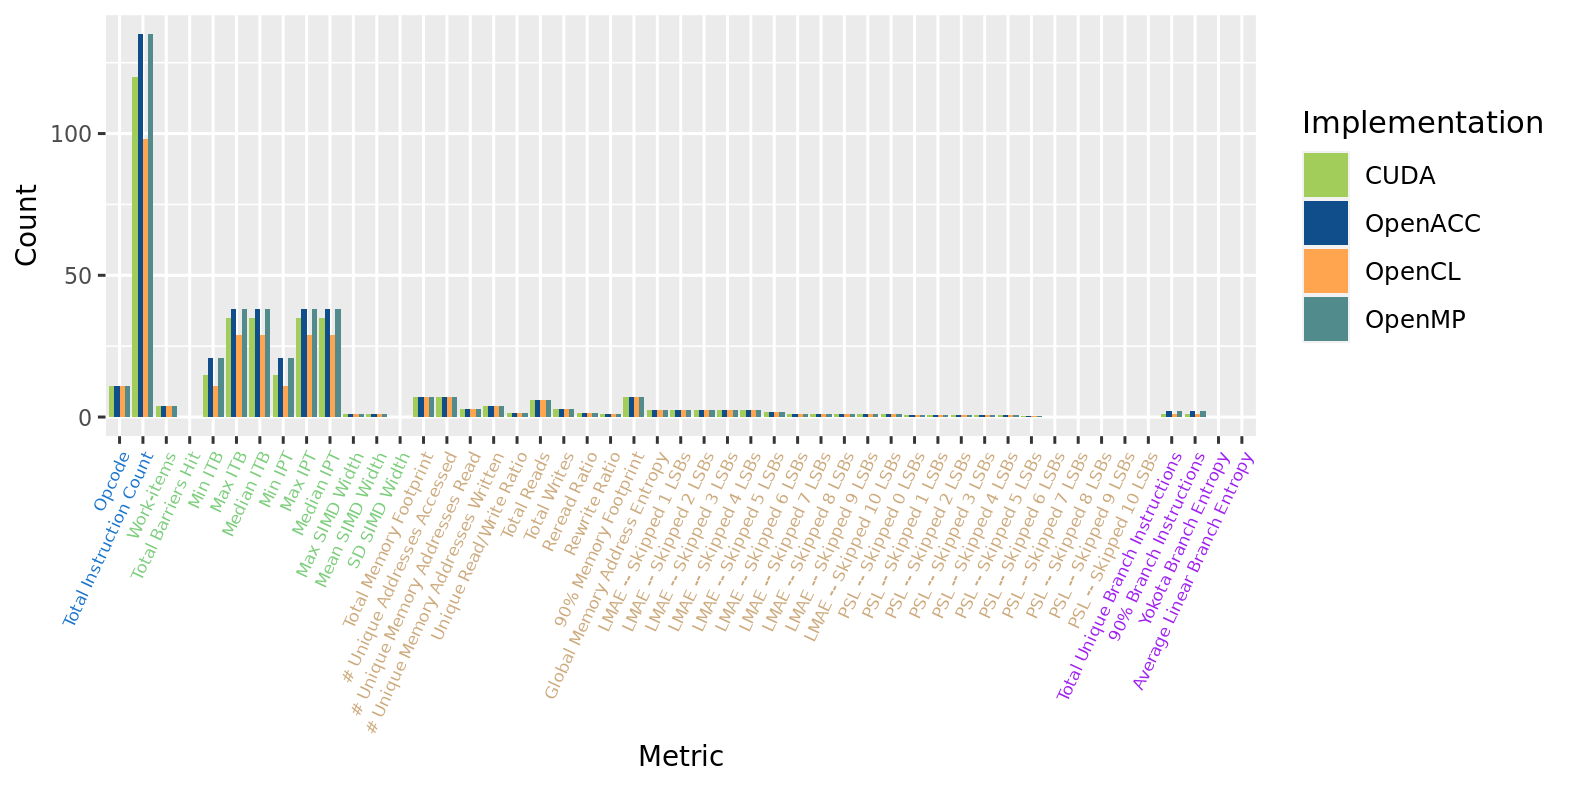

In [13]:
%%R -i fan1_invo0 -w 20 -h 10 --units cm -r 200

library('ggplot2')
library(broman)
library(viridis)

dat <- fan1_invo0
ordered_categories <- dat[dat$implementation=="cuda",]$category

dat[dat$implementation=="cuda",]$implementation <- "CUDA"
dat[dat$implementation=="openmp",]$implementation <- "OpenMP"
dat[dat$implementation=="openacc",]$implementation <- "OpenACC"
dat[dat$implementation=="opencl",]$implementation <- "OpenCL"

# The four categories to assign are: "Compute","Parallelism","Memory","Control"
category_colours <- switchv(as.character(ordered_categories), "Parallelism" = "palegreen3", "Compute" = "dodgerblue3", "Memory" = "burlywood3", "Control" = "purple", "red")#red is unknown categories
#print(category_colours)
p <- ggplot(data=dat, aes(x=metric,y=count,fill=implementation)) +
        geom_bar(position="dodge", stat = "identity") +
        theme(axis.text.y = element_text(size = 8),
              axis.text.x = element_text(size=6, hjust = 1,angle=65, colour=category_colours),
              axis.title.x = element_text(size=10),
              axis.title.y = element_text(size=10))
p <- p + scale_fill_manual(values = c("darkolivegreen3", "dodgerblue4", "tan1","darkslategray4"),"Implementation")
p <- p + labs(y = "Count",x="Metric",fill="Implementation")

#p <- p + scale_fill_viridis_d(option = "plasma","Implementation")
print(p)
ggsave("figures/fan1_absolute.pdf",p)

Initially, we performed the analysis of the feature-spaces directly from the Rodinia Benchmark Suite. However, a comparison of the AIWC metrics revealed three metrics which were largely affected by not partitioning work identically between implementations. These were `workitems`, `operand sum` and `total instruction count`. To address this, the benchmarks were modified to express an identical amount of parallelism, these changes are outlined in the following code-blocks.

The OpenCL implementation was changed in the following way:

In [12]:
! git diff pre_fan1_parallelism_changes HEAD -- gaussian_opencl_version/gaussianElim.cpp 

diff --git a/codes/gaussian_opencl_version/gaussianElim.cpp b/codes/gaussian_opencl_version/gaussianElim.cpp
index 094f561..2933930 100755
--- a/codes/gaussian_opencl_version/gaussianElim.cpp
+++ b/codes/gaussian_opencl_version/gaussianElim.cpp
@@ -1,6 +1,7 @@







@@ -162,11 +163,17 @@ void ForwardSub(cl_context context, float *a, float *b, float *m, int size,int t




















@@ -174,16 +181,15 @@ void ForwardSub(cl_context context, float *a, float *b, float *m, int size,int t





















To be consistant with the parallelism expressed in the OpenCL version the CUDA implementation was modified in the following way:

In [13]:
! git diff pre_fan1_parallelism_changes HEAD -- gaussian_cuda_version/gaussian.cu 

diff --git a/codes/gaussian_cuda_version/gaussian.cu b/codes/gaussian_cuda_version/gaussian.cu
index ba37d93..5120798 100755
--- a/codes/gaussian_cuda_version/gaussian.cu
+++ b/codes/gaussian_cuda_version/gaussian.cu
@@ -260,9 +260,11 @@ void ForwardSub()
 	cudaMemcpy(b_cuda, b, Size * sizeof(float),cudaMemcpyHostToDevice );
 	
 	int block_size,grid_size;
-	
-	block_size = MAXBLOCKSIZE;
+	//if we have smaller work to do than the max block size, just run 1 block of that size
+	block_size = (Size % MAXBLOCKSIZE == 0) ? MAXBLOCKSIZE : Size;
 	grid_size = (Size/block_size) + (!(Size%block_size)? 0:1);
+    //block_size = 1;
+    //grid_size = 1;
 	//printf("1d grid size: %d\n",grid_size);
 
 
@@ -276,7 +278,7 @@ void ForwardSub()
 	
 	dim3 dimBlockXY(blockSize2d,blockSize2d);
 	dim3 dimGridXY(gridSize2d,gridSize2d);
-
+    printf("sizing info: %dx%d blocks, in a %dx%d grid\n",blockSize2d,blockSize2d,gridSize2d,gridSize2d);
     // begin timing kernels
     struct timeval time_start;
     g

It is apparent the initial benchmark implementations have a variation in parallelism due to the way it is expressed in CUDA compared to OpenCL.
The `Block` size was explicitly set to the `MAXBLOCKSIZE` (512 threads), our change: `block_size = (Size % MAXBLOCKSIZE == 0) ? MAXBLOCKSIZE : Size;` states that if we have smaller work to do than the max block size, just run 1 block of that size, which mirrors the way OpenCL expresses parallelism of this benchmark -- i.e. the `global workgroup size` is the total number of threads to execute run in teams of `local workgroup size`. Thus, the CUDA implementation went from `512` workitems being invoked (where only 4 of them did any meaningful work) to `4` workitems being run.

The OpenACC implementation was also modified:

In [14]:
! git diff pre_fan1_parallelism_changes HEAD -- gaussian_openacc_version/gaussian.c

diff --git a/codes/gaussian_openacc_version/gaussian.c b/codes/gaussian_openacc_version/gaussian.c
index 8f42354..1bc0753 100755
--- a/codes/gaussian_openacc_version/gaussian.c
+++ b/codes/gaussian_openacc_version/gaussian.c
@@ -19,9 +19,10 @@
 #include <string.h>
 
 int Size;
+int fan1_workers,fan1_gangs,fan2_workers,fan2_gangs;
 float *a, *b, *finalVec;
 float *m;
-
+#define MAXBLOCKSIZE 512
 FILE *fp;
 
 void InitProblemOnce(char *filename);
@@ -78,7 +79,6 @@ int main(int argc, char *argv[])
     InitPerRun(m);
     //begin timing
     gettimeofday(&time_start, NULL);	
-    
     // run kernels
     ForwardSub();
     
@@ -139,7 +139,10 @@ void InitProblemOnce(char *filename)
 	//printf("The input matrix a is:\n");
 	//PrintMat(a, Size, Size);
 	b = (float *) malloc(Size * sizeof(float));
-	
+    fan1_gangs = (Size % MAXBLOCKSIZE == 0) ? MAXBLOCKSIZE : Size;
+    fan1_workers = (Size/fan1_gangs) + (!(Size%fan1_gangs)? 0:1);
+    fan2_gangs = fan1_gangs*fan1_gangs;
+    fan2_workers 

OpenARC uses `workers` and `gangs` variables to express parallelism in the OpenACC to OpenCL setting.
To this end, we added these variables and the `MAXBLOCKSIZE` to be 512 to be equivilent to the CUDA version of the Gaussian Elimination benchmark.
`gangs = (Size % MAXBLOCKSIZE == 0) ? MAXBLOCKSIZE : Size;` is set to be analagous to `block_size` (`block_size = (Size % MAXBLOCKSIZE == 0) ? MAXBLOCKSIZE : Size;`) which we added to the CUDA version, similarly, `workers = (Size/gangs) + (!(Size%gangs)? 0:1);` is identical to the CUDA version of `grid_size` (`grid_size = (Size/block_size) + (!(Size%block_size)? 0:1);`).
Finally, the OpenACC pragmas where modified to explicitly use the `workers` and `gangs` variables: from `#pragma acc parallel loop present(m,a)` to `#pragma acc kernels loop independent gang(gangs) worker(workers)`.

It is also worth mentioning that two separate loops in the `Fan2` function were consolidated into one, to mirror how the task is performed in the OpenCL and CUDA implementations of the algorithm.

In summary, the OpenACC implementation went from `64` workitems being invoked (where only 4 of them did any meaningful work) to `4` workitems being run.
The full OpenCL, CUDA, OpenACC and OpenMP source codes are shown below.

In [54]:
! cat gaussian_opencl_version/gaussianElim_kernels.cl

In [48]:
! cat gaussian_cuda_version/gaussian.cu 

/*-----------------------------------------------------------
 ** gaussian.cu -- The program is to solve a linear system Ax = b
 **   by using Gaussian Elimination. The algorithm on page 101
 **   ("Foundations of Parallel Programming") is used.  
 **   The sequential version is gaussian.c.  This parallel 
 **   implementation converts three independent for() loops 
 **   into three Fans.  Use the data file ge_3.dat to verify 
 **   the correction of the output. 
 **
 ** Written by Andreas Kura, 02/15/95
 ** Modified by Chong-wei Xu, 04/20/95
 ** Modified by Chris Gregg for CUDA, 07/20/2009
 **-----------------------------------------------------------
 */
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include "cuda.h"
#include <string.h>

#define MAXBLOCKSIZE 512

int Size;
float *a, *b, *finalVec;
float *m;

FILE *fp;

void InitProblemOnce(char *filename);
void InitPerRun();
void ForwardSub();
void BackSub();
void InitMat(float *ary, int nrow, int ncol);
void InitAry(f

In [50]:
! cat gaussian_openacc_version/gaussian.c

/*-----------------------------------------------------------
 ** gaussian.c -- The program is to solve a linear system Ax = b
 **   by using Gaussian Elimination. The algorithm on page 101
 **   ("Foundations of Parallel Programming") is used.  
 **   The sequential version is gaussian.c.  This parallel 
 **   implementation converts three independent for() loops 
 **   into three Fans.  Use the data file ge_3.dat to verify 
 **   the correction of the output. 
 **
 ** Written by Andreas Kura, 02/15/95
 ** Modified by Chong-wei Xu, 04/20/95
 ** Modified by Chris Gregg for CUDA, 07/20/2009
 ** Modified by Pisit Makpaisit for OpenACC, 08/05/2013
 **-----------------------------------------------------------
 */
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <string.h>

int Size;
int fan1_workers,fan1_gangs,fan2_workers,fan2_gangs;
float *a, *b, *finalVec;
float *m;
#define MAXBLOCKSIZE 512
FILE *fp;

void InitProblemOnce(char *filename);
void InitPerRun(float *m);

In [55]:
! cat gaussian_openmp_version/gaussian.c

/*-----------------------------------------------------------
 ** gaussian.c -- The program is to solve a linear system Ax = b
 **   by using Gaussian Elimination. The algorithm on page 101
 **   ("Foundations of Parallel Programming") is used.  
 **   The sequential version is gaussian.c.  This parallel 
 **   implementation converts three independent for() loops 
 **   into three Fans.  Use the data file ge_3.dat to verify 
 **   the correction of the output. 
 **
 ** Written by Andreas Kura, 02/15/95
 ** Modified by Chong-wei Xu, 04/20/95
 ** Modified by Chris Gregg for CUDA, 07/20/2009
 ** Modified by Pisit Makpaisit for OpenACC, 08/05/2013
 ** Modified by Beau Johnston for OpenMP, 01/10/2019
 **-----------------------------------------------------------
 */
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <string.h>

int Size;
int fan1_threads,fan1_teams,fan2_threads,fan2_teams;
float *a, *b, *finalVec;
float *m;
#define MAXBLOCKSIZE 512
FILE *fp;

void InitPr

Since the OpenCL AIWC feature-space is the baseline, we should express this difference as a ratio of the CUDA and OpenACC implementations relative to the OpenCL version.

### Fan1 Relative AIWC Counts

R[write to console]: Saving 7.87 x 3.94 in image



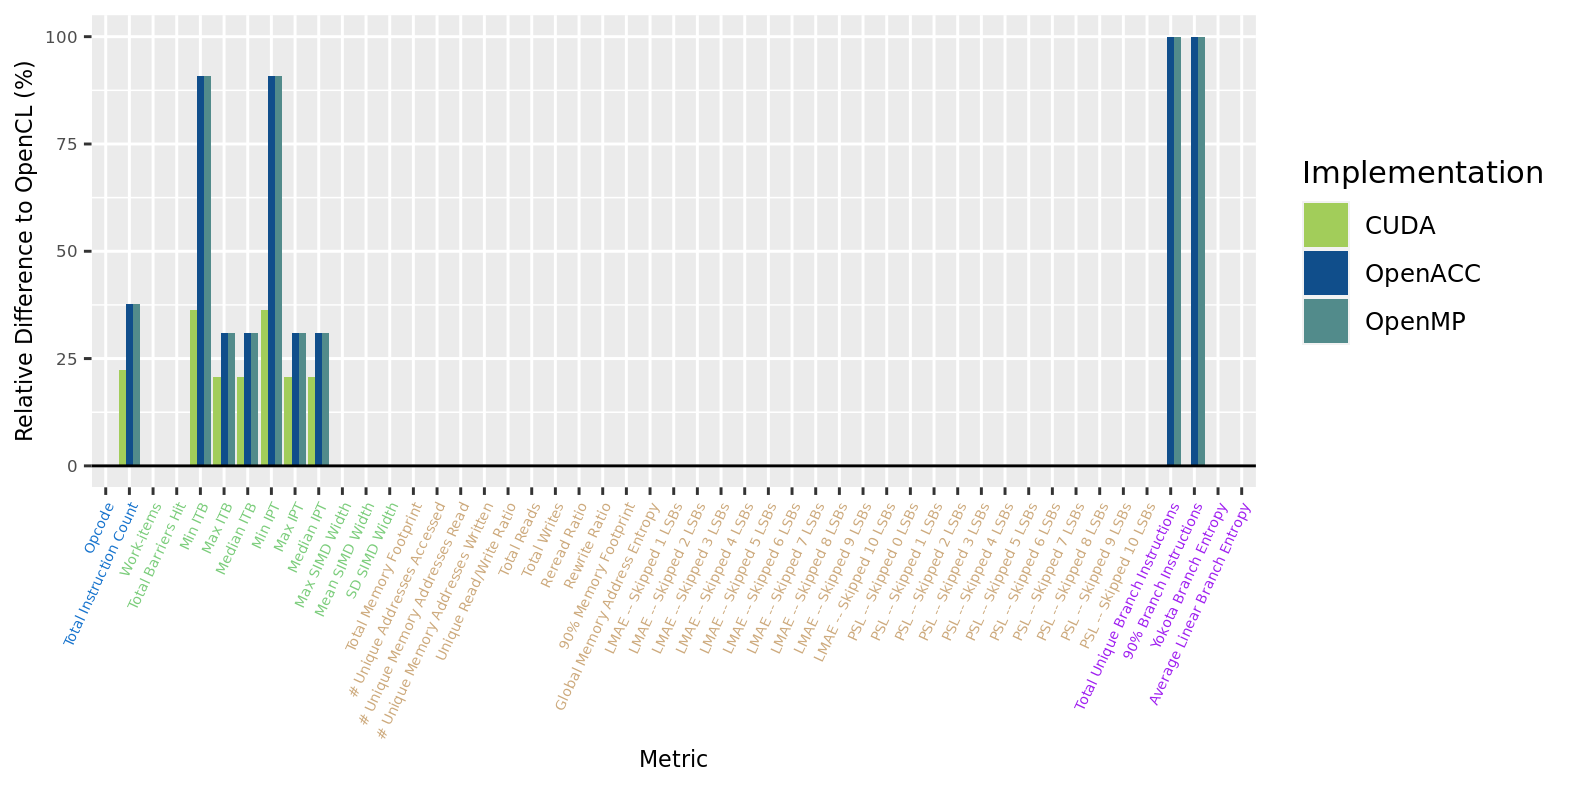

In [14]:
%%R -i fan1_invo0 -w 20 -h 10 --units cm -r 200

is.nan.data.frame <- function(x){
    do.call(cbind, lapply(x, is.nan))
}

#normalize against the OpenCL AIWC metrics...
dat <- data.frame()
for (i in unique(fan1_invo0$metric)){
    cud = fan1_invo0[fan1_invo0$metric == i & fan1_invo0$implementation == 'cuda',]
    ocl = fan1_invo0[fan1_invo0$metric == i & fan1_invo0$implementation == 'opencl',]
    acc = fan1_invo0[fan1_invo0$metric == i & fan1_invo0$implementation == 'openacc',]
    omp = fan1_invo0[fan1_invo0$metric == i & fan1_invo0$implementation == 'openmp',]


    cud$count = cud$count/ocl$count
    acc$count = acc$count/ocl$count
    omp$count = omp$count/ocl$count
    
    dat <- rbind(dat,cud,acc,omp)
}

#some metrics are 0 and divided by zero produce NaNs -- since we want to show that they are both the same when compared to the OpenCL baseline set them to be 1
dat[is.nan(dat)] <- 1

library('ggplot2')
library('broman')

# The four categories to assign are: "compute","parallelism","memory","control"
ordered_categories <- dat[dat$implementation=="cuda",]$category
category_colours <- switchv(as.character(ordered_categories), "Parallelism" = "palegreen3", "Compute" = "dodgerblue3", "Memory" = "burlywood3", "Control" = "purple", "red")#red is unknown categories
dat[dat$implementation=="cuda",]$implementation <- "CUDA"
dat[dat$implementation=="openmp",]$implementation <- "OpenMP"
dat[dat$implementation=="openacc",]$implementation <- "OpenACC"

# plot the differences in AIWC metrics
p <- ggplot(data=dat, aes(x=metric,y=(count*100)-100,fill=implementation)) +
        geom_bar(position="dodge",stat = "identity") +
        theme(axis.text.y = element_text(size = 6),
              axis.text.x = element_text(size = 5,hjust = 1,angle=65,colour=category_colours),
              axis.title.x = element_text(size=8),
              axis.title.y = element_text(size=8)) +
        labs(y = "Relative Difference to OpenCL (%)",x="Metric",fill="Implementation")
p <- p + scale_fill_manual(values = c("darkolivegreen3", "dodgerblue4","darkslategray4"))
p <- p + geom_hline(yintercept=0)
print(p)
ggsave("figures/fan1_relative_difference.pdf",p)

#p <- ggplot(data=dat, aes(x=metric,y=(count*100),fill=implementation)) +
#        geom_bar(position="dodge",stat = "identity") +
#        theme(axis.text.y = element_text(size = 6),
#              axis.text.x = element_text(size = 5,hjust = 1,angle=65,colour=category_colours),
#              axis.title.x = element_text(size=8),
#              axis.title.y = element_text(size=8)) +
#        labs(y = "Relative to OpenCL (%)",x="Metric",fill="Implementation")
#p <- p + scale_fill_manual(values = c("darkolivegreen3", "dodgerblue4","darkslategray4"))
#print(p)
#ggsave("figures/fan1_relative.pdf",p)

#library(patternplot)
#pattern.type<-c('hdashes', 'vdashes', 'bricks')
#pattern.color=c('black','white', 'grey20')
#background.color=c("darkolivegreen3", "dodgerblue4","darkslategray4")
#density<-c(20, 20, 10)
#barp2<-patternbar(dat,x=dat$metric,y=dat$count*100,group=dat$implementation,ylab="Implementation", pattern.type=pattern.type,hjust=0.5,
#           pattern.color=pattern.color, background.color=background.color,pattern.line.size=c(5.5, 1, 4),
#           frame.color=c('black', 'black', 'black'), density=density)+scale_y_continuous(limits = c(0, 2800))+ggtitle('(B) Colors with Patterns')
#print(barp2)



In this relative figure, the CUDA and OpenACC variants would be identical if all metrics were at 100% of the OpenCL baseline counts.
Examining the generated LLVM-IR code will identify the differences between language implementations.
Firstly, the initial OpenCL version:

# Source-Code Comparison

In [43]:
! cat gaussian_opencl_version/gaussianElim_kernels.cl

In [47]:
! cat gaussian_openacc_version/bin/openarc_kernel.cl

#ifndef __OpenCL_KERNELHEADER__ 
#define __OpenCL_KERNELHEADER__ 
/**********************************************/
/* Added codes for OpenACC2OpenCL translation */
/**********************************************/
#ifdef __cplusplus
#define restrict __restrict__
#endif
#define MAX(a,b) (((a) > (b)) ? (a) : (b))
#define MIN(a,b) (((a) < (b)) ? (a) : (b))
#ifndef FLT_MAX
#define FLT_MAX 3.402823466e+38
#endif
#ifndef FLT_MIN
#define FLT_MIN 1.175494351e-38
#endif
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#ifndef DBL_MAX
#define DBL_MAX 1.7976931348623158e+308
#endif
#ifndef DBL_MIN
#define DBL_MIN 2.2250738585072014e-308
#endif
#endif


__kernel void  Fan1_kernel0(__global float * a, __global float * m, int Size, int fan1_gangs, int fan1_workers, int t)
{
int _ti_100_501;
int lwpriv__i;
_ti_100_501=get_global_id(0);
#pragma acc  kernels loop gang(fan1_gangs) worker(fan1_workers) independent copyin(Size, t) present(a[0:(Size*Size)], m[0:(Size*Size)]) private(i)
if (_ti_100_501<(get_num_

# LLVM Comparison

In [29]:
! /coriander/soft/llvm-3.9.0.bin/bin/clang -cc1 ./gaussian_opencl_version/gaussianElim_kernels.cl -emit-llvm -o ocl_kernel.ll && cat ocl_kernel.ll

./gaussian_opencl_version/gaussianElim_kernels.cl:14:15: warning: implicit declaration of function 'get_local_id' is invalid in C99
    int gid = get_local_id(0) + get_group_id(0) * get_local_size(0) ;//get_global_id(0);
              ^
./gaussian_opencl_version/gaussianElim_kernels.cl:14:33: warning: implicit declaration of function 'get_group_id' is invalid in C99
    int gid = get_local_id(0) + get_group_id(0) * get_local_size(0) ;//get_global_id(0);
                                ^
./gaussian_opencl_version/gaussianElim_kernels.cl:14:51: warning: implicit declaration of function 'get_local_size' is invalid in C99
    int gid = get_local_id(0) + get_group_id(0) * get_local_size(0) ;//get_global_id(0);
                                                  ^
./gaussian_opencl_version/gaussianElim_kernels.cl:26:18: warning: implicit declaration of function 'get_global_id' is invalid in C99
         int globalId = get_global_id(0);
                        ^
4 warnings generated.
; ModuleID

The CUDA version (the intermediate SPIR is generated directly as a compiliation step in Coriander):

In [400]:
! cp ./gaussian_opencl-device.ll ./cud_kernel.ll && cat ./cud_kernel.ll

; ModuleID = './gaussian_opencl-device-noopt.ll'
source_filename = "./gaussian_cuda_version/gaussian.cu"
target datalayout = "e-i64:64-v16:16-v32:32-n16:32:64"
target triple = "nvptx64-nvidia-cuda"

@llvm.used = appending global [1 x i8*] [i8* bitcast (i32 ()* @_ZL21__nvvm_reflect_anchorv to i8*)], section "llvm.metadata"

; Function Attrs: norecurse nounwind readnone
define internal i32 @_ZL21__nvvm_reflect_anchorv() #0 {
  ret i32 0
}

; Function Attrs: nounwind
define void @_Z4Fan1PfS_ii(float* nocapture, float* nocapture readonly, i32, i32) local_unnamed_addr #1 {
  %5 = tail call i32 @llvm.nvvm.read.ptx.sreg.tid.x() #3, !range !5
  %6 = tail call i32 @llvm.nvvm.read.ptx.sreg.ctaid.x() #3, !range !6
  %7 = tail call i32 @llvm.nvvm.read.ptx.sreg.ntid.x() #3, !range !7
  %8 = mul i32 %7, %6
  %9 = add i32 %8, %5
  %10 = add nsw i32 %2, -1
  %11 = sub i32 %10, %3
  %12 = icmp slt i32 %9, %11
  br i1 %12, label %13, label %30

; <label>:13:                                     ; preds =

OpenACC:

In [397]:
! /coriander/soft/llvm-3.9.0.bin/bin/clang -cc1 gaussian_openacc_version/bin/openarc_kernel.cl -emit-llvm -o acc_kernel.ll && cat acc_kernel.ll

gaussian_openacc_version/bin/openarc_kernel.cl:31:13: warning: implicit declaration of function 'get_global_id' is invalid in C99
_ti_100_501=get_global_id(0);
            ^
gaussian_openacc_version/bin/openarc_kernel.cl:33:18: warning: implicit declaration of function 'get_num_groups' is invalid in C99
if (_ti_100_501<(get_num_groups(0)*fan1_workers))
                 ^
2 warnings generated.
; ModuleID = 'gaussian_openacc_version/bin/openarc_kernel.cl'
source_filename = "gaussian_openacc_version/bin/openarc_kernel.cl"
target datalayout = "e-m:e-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

; Function Attrs: nounwind
define void @Fan1_kernel0(float* nocapture readonly %a, float* nocapture %m, i32 %Size, i32 %fan1_gangs, i32 %fan1_workers, i32 %t) local_unnamed_addr #0 !kernel_arg_addr_space !1 !kernel_arg_access_qual !2 !kernel_arg_type !3 !kernel_arg_base_type !3 !kernel_arg_type_qual !4 {
  %call = tail call i32 (i32, ...) bitcast (i32 (...)* @get_globa

Finally, OpenMP:

In [17]:
! /coriander/soft/llvm-3.9.0.bin/bin/clang -cc1 gaussian_openmp_version/bin/openarc_kernel.cl -emit-llvm -o omp_kernel.ll && cat omp_kernel.ll

gaussian_openmp_version/bin/openarc_kernel.cl:31:13: warning: implicit declaration of function 'get_global_id' is invalid in C99
_ti_100_501=get_global_id(0);
            ^
gaussian_openmp_version/bin/openarc_kernel.cl:33:18: warning: implicit declaration of function 'get_num_groups' is invalid in C99
if (_ti_100_501<(get_num_groups(0)*fan1_threads))
                 ^
2 warnings generated.
; ModuleID = 'gaussian_openmp_version/bin/openarc_kernel.cl'
source_filename = "gaussian_openmp_version/bin/openarc_kernel.cl"
target datalayout = "e-m:e-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

; Function Attrs: nounwind
define void @Fan1_kernel0(i32 %lfpriv__Size, i32 %lfpriv__t, float* nocapture readonly %a, float* nocapture %m, i32 %fan1_teams, i32 %fan1_threads) local_unnamed_addr #0 !kernel_arg_addr_space !1 !kernel_arg_access_qual !2 !kernel_arg_type !3 !kernel_arg_base_type !3 !kernel_arg_type_qual !4 {
  %call = tail call i32 (i32, ...) bitcast (i32 (...)

## CUDA vs OpenCL

When we examine the differences between the OpenCL and CUDA versions of this function, we notice the structure of the entry point (`define`) to be largely the same -- these are named `Fan1` and `_Z4Fan1PfS_ii` with respect to version. Both functions have three successive calls to get local and global thread ids and aquiring the size of the workgroup.

The ~25% variation in `Total Instruction Count`, `IPT` (Instructions Per Thread) and `IBT` (Instructions Per Barrier) between the CUDA to the OpenCL baseline is now discussed.
Firstly, the `Total Instruction Count` is the total number of instructions executed over all threads -- it is the sum of `IPT` * `Number of Workitems`.
Furthermore, since the Fan1 kernel has no explicit barriers (to synchronise between workitems) and has only one implicit barriers (when each workitem terminates), the `ITB` metrics should present identical results to `IPT` metrics.

A side-by-side comparison of the OpenCL and CUDA Fan1 kernels are presented below.

In [512]:
! sdiff data/opencl_fan1_kernel.ll data/cuda_fan1_kernel.ll | colordiff

; Function Attrs: nounwind                                      ; Function Attrs: nounwind
define void @Fan1(float* nocapture %m_dev, float* nocapture r | define void @_Z4Fan1PfS_ii(float* nocapture, float* nocapture
  %call = tail call i32 (i32, ...) bitcast (i32 (...)* @get_l |   %5 = tail call i32 @llvm.nvvm.read.ptx.sreg.tid.x() #3, !ra
  %call1 = tail call i32 (i32, ...) bitcast (i32 (...)* @get_ |   %6 = tail call i32 @llvm.nvvm.read.ptx.sreg.ctaid.x() #3, !
  %call2 = tail call i32 (i32, ...) bitcast (i32 (...)* @get_ |   %7 = tail call i32 @llvm.nvvm.read.ptx.sreg.ntid.x() #3, !r
  %mul = mul nsw i32 %call2, %call1                           |   %8 = mul i32 %7, %6
  %add = add nsw i32 %mul, %call                              |   %9 = add i32 %8, %5
  %sub = add nsw i32 %size, -1                                |   %10 = add nsw i32 %2, -1
  %sub3 = sub i32 %sub, %t                                    |   %11 = sub i32 %10, %3
  %cmp = icmp slt i32 %add, %sub3                     


### Trace Analysis

To examine these differences in seemingly identical LLVM-IR codes we added the printing of the name of each executed instruction thereby giving a trace of the OpenCL and CUDA versions.

This was achieved by adding:

````
if(workItem->getGlobalID()[0]==0){
   printf("%s\n",opcode_name.c_str());
}
````

To the function `instructionExecuted` which is triggered as a callback when the Oclgrind simulator executes each instruction.
Since oclgrind is a multithreaded program -- to the extent that each OpenCL workitem is run on a separate pthread -- we only print the log if it occurs on the first thread.
The default Gaussian Elimination test data is run on 4 threads and calls the `Fan1` and `Fan2` kernels three (3) times.
For this analysis we only store the traces of first execution of the `Fan1` kernel.

These traces were then piped from OpenCL and CUDA to `data/fan1_trace_opencl.txt` and `data/fan1_trace_cuda.txt` respectively.
The differences between traces are shown below followed by the differences in llvm outputs of the source kerrnels, OpenCL is on the left and CUDA on the right:

In [511]:
! sdiff data/fan1_trace_opencl.txt data/fan1_trace_cuda.txt | colordiff | nl -w2 

 1	                                                              > getelementptr
 2	                                                              > bitcast
 3	call                                                            call
 4	                                                              > trunc
 5	call                                                            call
 6	                                                              > trunc
 7	call                                                            call
 8	                                                              > trunc
 9	mul                                                             mul
10	add                                                             add
11	trunc                                                         <
12	add                                                             add
13	sub                                                             sub
14	icmp                                                   

At first glance, both LLVM outputs look identical, except for the change in label names.
An unexpected deviation from the trace vs the LLVM output in the OpenCL versions (the left hand side) is the added `trunc` as the 6th instruction (line 11), this does not appear explicitly in the .ll file.
This is suspected to be due to label `%size` -- the 3rd argument provided to the function -- being of type signed int 32 which then requires an explicit conversion of the (-1) variable to be also signed int 32 for the forthcoming subtraction operation to set %sub and thus it is added.
All other instructions in the kernel trace mirror exactly with the expected flow of instructions from looking at the llvm byte-code.

More interestingly is the wild variations in kernel traces from the byte-code -- especially prevalent in the beggining of the CUDA version.
Coriander performs one additional translation to the .ll file we examine here (`./gaussian_opencl-device.ll`) to be loaded in directly from the host (`./gaussian_opencl-hostpatched.ll`).
This patch replaces the `@llvm.nvvm.read.ptx.sreg.tid.x()`, `@llvm.nvvm.read.ptx.sreg.ctaid.x()` and `@llvm.nvvm.read.ptx.sreg.ntid.x()` with the corresponding OpenCL framework functions respectively, however these likely require an additional type conversion.
This explains the added `trunc` instructions interleaved between the `call`s in the CUDA trace -- in lines 4,6 and 8.

On entry into the kernel function there is an extra `getelementptr` and `bitcast` at the entry point of the function (lines 1 and 2) and approximately midway through the trace (lines 16-17).
These are added in the hostpatch step (from the Coriander framework) to deal with accessing `clmem` objects from the device -- an offset is added for each buffer passed into the kernel function.
The following `bitcast` is needed to convert these memory buffers into the appropriate type (in this instance 32-bit signed integers).
Since the `Fan1` uses two `clmem` objects we expect an additional four instructions to be used -- and will be included prior to these buffers being directly used.

The final difference in the CUDA version is that it's trace shows a reordering of lines 22-24 where the two `sext` instructions which are followed by two `getelementptr` instructions, it is unknown why this occurs but seems to occur after at the Coriander hostpatch level and are reordered into `sext`, `getelementptr`, `sext` and `getelementptr` while the OpenCL version maintains the order for the llvm source (`sext`->`sext`->`getelementptr`->`getelementptr`).

In summary, the Coriander backend adds `trunc` instructions after every `call`, and an additional `getelementptr` and `bitcast` is required for the first time each OpenCL memory buffer is used (`clmem`).


## OpenACC vs OpenCL

An examination of the differences between the OpenCL and OpenACC versions of the Fan1 function is provided below as a side-by-side comparison (on left and right sides respectively).

In [519]:
! pr -m -t data/opencl_fan1_kernel.ll data/openacc_fan1_kernel.ll | nl -w2 

 1	; Function Attrs: nounwind	    ; Function Attrs: nounwind
 2	define void @Fan1(float* nocapture  define void @Fan1_kernel0(float* no
 3	  %call = tail call i32 (i32, ...)  	%call = tail call i32 (i32, ...
 4	  %call1 = tail call i32 (i32, ...) 	%call1 = tail call i32 (i32, ..
 5	  %call2 = tail call i32 (i32, ...) 	%mul = mul nsw i32 %call1, %fan
 6	  %mul = mul nsw i32 %call2, %call1 	%cmp = icmp slt i32 %call, %mul
 7	  %add = add nsw i32 %mul, %call    	br i1 %cmp, label %.preheader,
 8	  %sub = add nsw i32 %size, -1	    
 9	  %sub3 = sub i32 %sub, %t	    	.preheader:
10	  %cmp = icmp slt i32 %add, %sub3   	%sub = add nsw i32 %Size, -1
11	  br i1 %cmp, label %1, label %4    	%sub2 = sub i32 %sub, %t
12					    	%cmp338 = icmp slt i32 %call, %
13	; <label>:1:			    	br i1 %cmp338, label %.lr.ph, l
14	  %add4 = add i32 %t, 1		    
15	  %add5 = add i32 %add4, %add	    	.lr.ph:
16	  %mul6 = mul nsw i32 %add5, %size  	%add4 = add i32 %t, 1
17	  %idx.ext = sext i32 %mul6 to i64  	%mul8

We see a fundamental difference in the code structure -- with the OpenACC version containing more labelled code blocks and gotos -- and is believed to be due to the way access patterns are expressed when using directive-based approaches.
There added branching logic, first there is computing the global workitem identifier before hitting the `if (gid < size-1-t)` logic statement -- and is largely the same in all implementations -- followed by the added logic at the end of the main body of work (`<label>:1`) at line 35-40 which corresponds to a `for` loop which **TODO**(**HERE**).
These additional steps are unique to the directives based approaches.
There is also an additional comparison and jump form the definition of the `Fan1_kernel0` function, an additional `preheader` but has the same `add` -> `sub` -> `icmp` -> `br` that is included in the definition of the OpenCL and CUDA variations.
Which explains why the OpenACC version contains twice the number of `90% branch instructions` and `total unique branch instructions` than the OpenCL and CUDA variations -- as shown in the [absolute](#Fan1-Absolute-AIWC-Counts) and [relative](#Fan1-Relative-AIWC-Counts) Figures.


### Trace Analysis
The following is a difference in traces between the baseline OpenCL (left) and OpenACC (right).

In [513]:
! sdiff data/fan1_trace_opencl.txt data/fan1_trace_openacc.txt | colordiff | nl -w2 

 1	call                                                            call
 2	                                                              > trunc
 3	                                                              > sext
 4	call                                                            call
 5	call                                                          | sext
 6	mul                                                             mul
 7	add                                                           <
 8	trunc                                                         <
 9	add                                                           <
10	sub                                                           <
11	icmp                                                            icmp
12	br                                                              br
13	add                                                             add
14	                                                              > sub
15	add          

Firstly, there are only two calls to the OpenCL runtime, to get the global id and the number of groups in the kernel run.
These are passed as kernel arguments internally from the OpenARC framework.
Both calls require some conversion for the 

## Absolute Counts


| **Implementation** | **Total Instruction Count** | **Min IPT** | **Median IPT** | **Additional Instructions** |
| ------------------ | --------------------------- | ----------- | -------------- | --------------------------- |
| OpenCL             | 98                          | 11          | 29             | 0                           |
| CUDA               | 120                         | 15          | 35             | 22                          |
| OpenACC            | 135                         | 21          | 38             | 37                          |


Presents a table of AIWC instruction counts measured counts, as generated on with 4 workitems.
It is used to quantify the difference each alternative language implmentation has on these metrics.
The **Total Instruction Count** is the combined sum of all work-items executed over all threads over a given run.
It is computed indepentently of the other metric combination in the AIWC tool.
When viewed with the Instructions Per Thread summary statistics (**Min IPT** and **Median IPT**) we can conclude that over the 4 workitems initiated, only 3 of them do any real work, while one workitem only computes the global workitem identifier before hitting the `if (gid < size-1-t)` logic before breaking out (jumping to the `ret` and leaving the function).
Each implmentation of **Total Instruction Count** can also be computed as a combination as 3 * **Median IPT** + **Min IPT**, reinforcing our belief that this count is measured correctly.
The **Additional Instructions** is the total increase in the number of instructions collected with AIWC associated with using an implementation other than the OpenCL Baseline.

Thankfully, AIWC collects the overheads of the conversion from the CUDA and OpenACC implementations.
These changes only increase the number of instructions executed when comparing the OpenCL to CUDA and OpenCL to OpenACC variants and the entropy scores -- for both control-flow branching and memory accesses -- are unaffected.
The AIWC feature-spaces between these implemenations is similar, indicating the essence of the AIWC metric for that kernel is preserved irrespective of the varient of language in which it is presented.


## Fan2

In [31]:
%%R -o fan2_invo0

# load the data
cud <- read.csv('./gaussian_results/cuda/aiwc__Z4Fan2PfS_S_iii_0.csv')
ocl <- read.csv('./gaussian_results/opencl/aiwc_Fan2_0.csv')
acc <- read.csv('./gaussian_results/openacc/aiwc_Fan2_kernel0_0.csv')

# tag the implementation
cud$implementation <- "cuda"
ocl$implementation <- "opencl"
acc$implementation <- "openacc"
omp$implementation <- "openmp"

# bring it together
dat <- rbind(cud,ocl,acc,omp)

library('gtools')
#reorder the metrics according to category
dat <- dat[order(mixedsort(dat$category)),]
dat <- dat[order(mixedsort(dat$metric)),]
dat$metric <- factor(dat$metric, levels = unique(dat$metric)) #and lock-in/preserve the order

fan2_invo0 <- dat


### Fan2 Absolute AIWC Counts

R[write to console]: Saving 7.87 x 3.94 in image



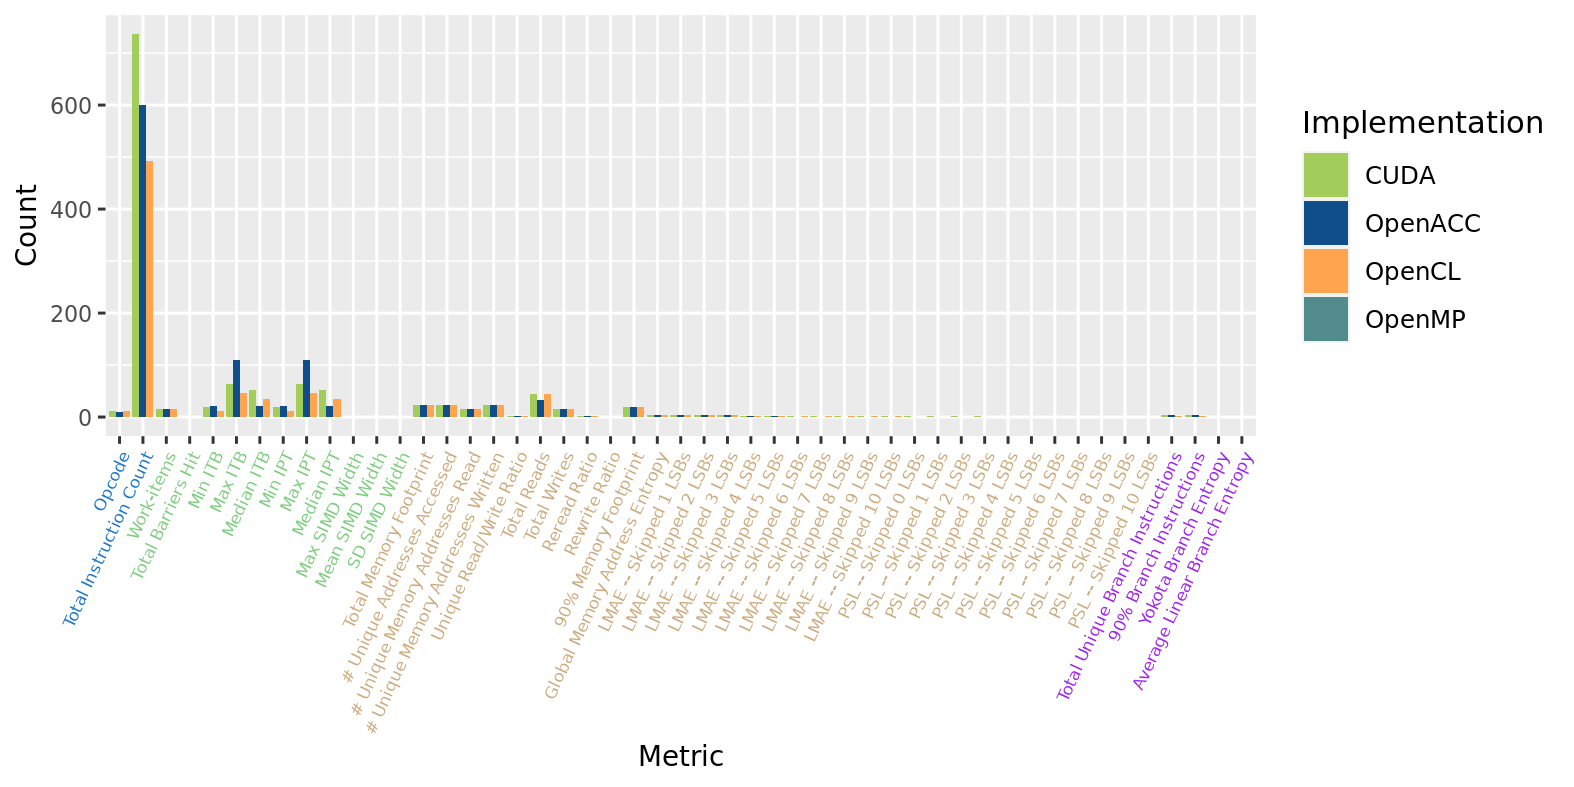

In [34]:
%%R -i fan2_invo0 -w 20 -h 10 --units cm -r 200

library('ggplot2')
library(broman)
library(viridis)

dat <- fan2_invo0
ordered_categories <- dat[dat$implementation=="cuda",]$category

dat[dat$implementation=="cuda",]$implementation <- "CUDA"
dat[dat$implementation=="openmp",]$implementation <- "OpenMP"
dat[dat$implementation=="openacc",]$implementation <- "OpenACC"
dat[dat$implementation=="opencl",]$implementation <- "OpenCL"

# The four categories to assign are: "Compute","Parallelism","Memory","Control"
category_colours <- switchv(as.character(ordered_categories), "Parallelism" = "palegreen3", "Compute" = "dodgerblue3", "Memory" = "burlywood3", "Control" = "purple", "red")#red is unknown categories
#print(category_colours)
p <- ggplot(data=dat, aes(x=metric,y=count,fill=implementation)) +
        geom_bar(position="dodge", stat = "identity") +
        theme(axis.text.y = element_text(size = 8),
              axis.text.x = element_text(size=6, hjust = 1,angle=65, colour=category_colours),
              axis.title.x = element_text(size=10),
              axis.title.y = element_text(size=10))
p <- p + scale_fill_manual(values = c("darkolivegreen3", "dodgerblue4", "tan1","darkslategray4"),"Implementation")
p <- p + labs(y = "Count",x="Metric",fill="Implementation")

#p <- p + scale_fill_viridis_d(option = "plasma","Implementation")
print(p)
ggsave("figures/fan2_absolute.pdf",p)

Since the OpenCL AIWC feature-space is the baseline, we should express this difference as a ratio of the CUDA and OpenACC implementations relative to the OpenCL version.

### Fan2 Relative AIWC Counts

R[write to console]: Saving 7.87 x 3.94 in image

R[write to console]: Saving 7.87 x 3.94 in image



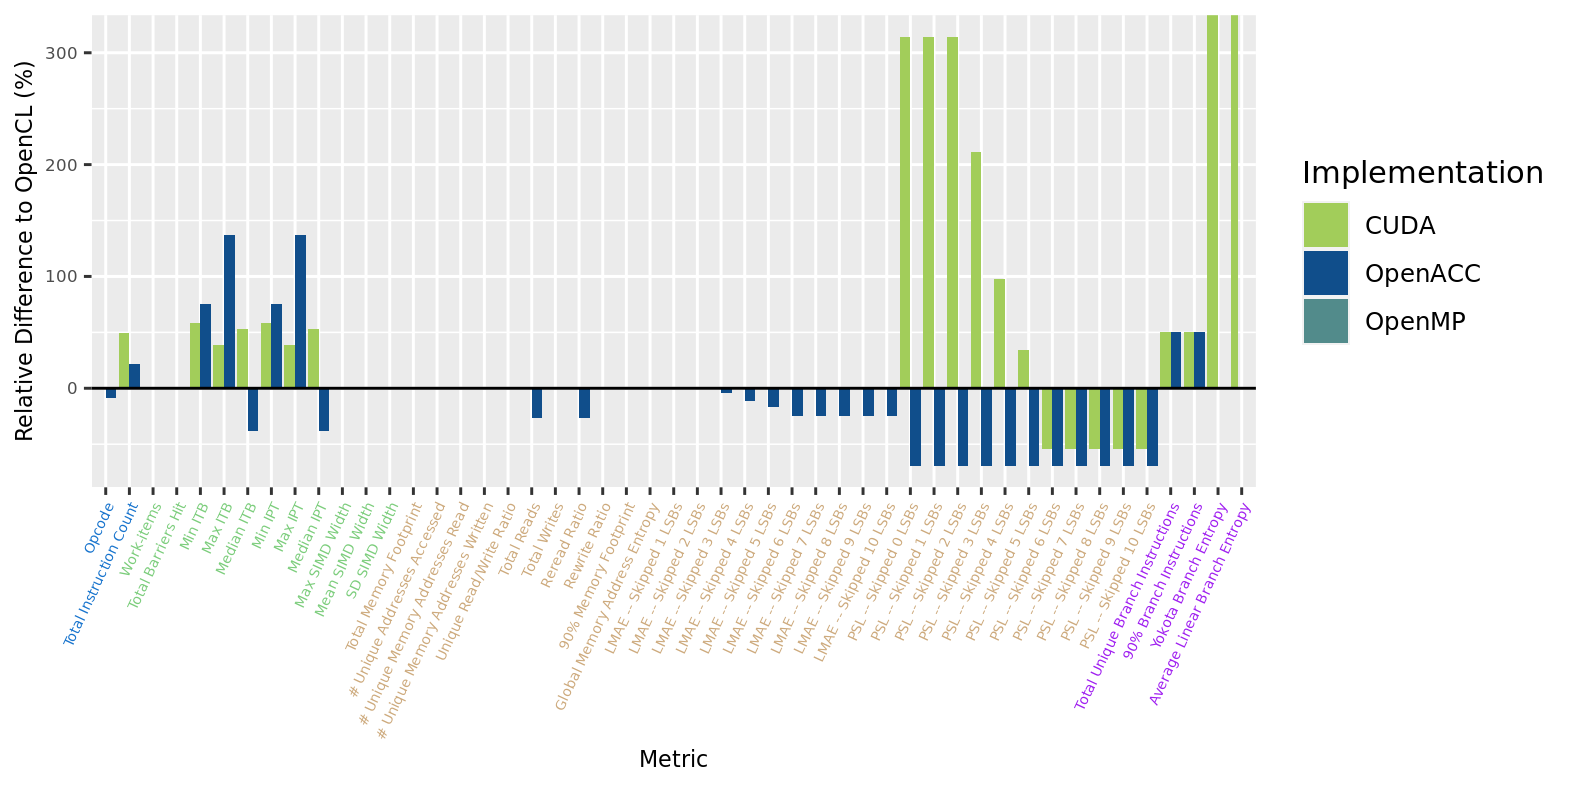

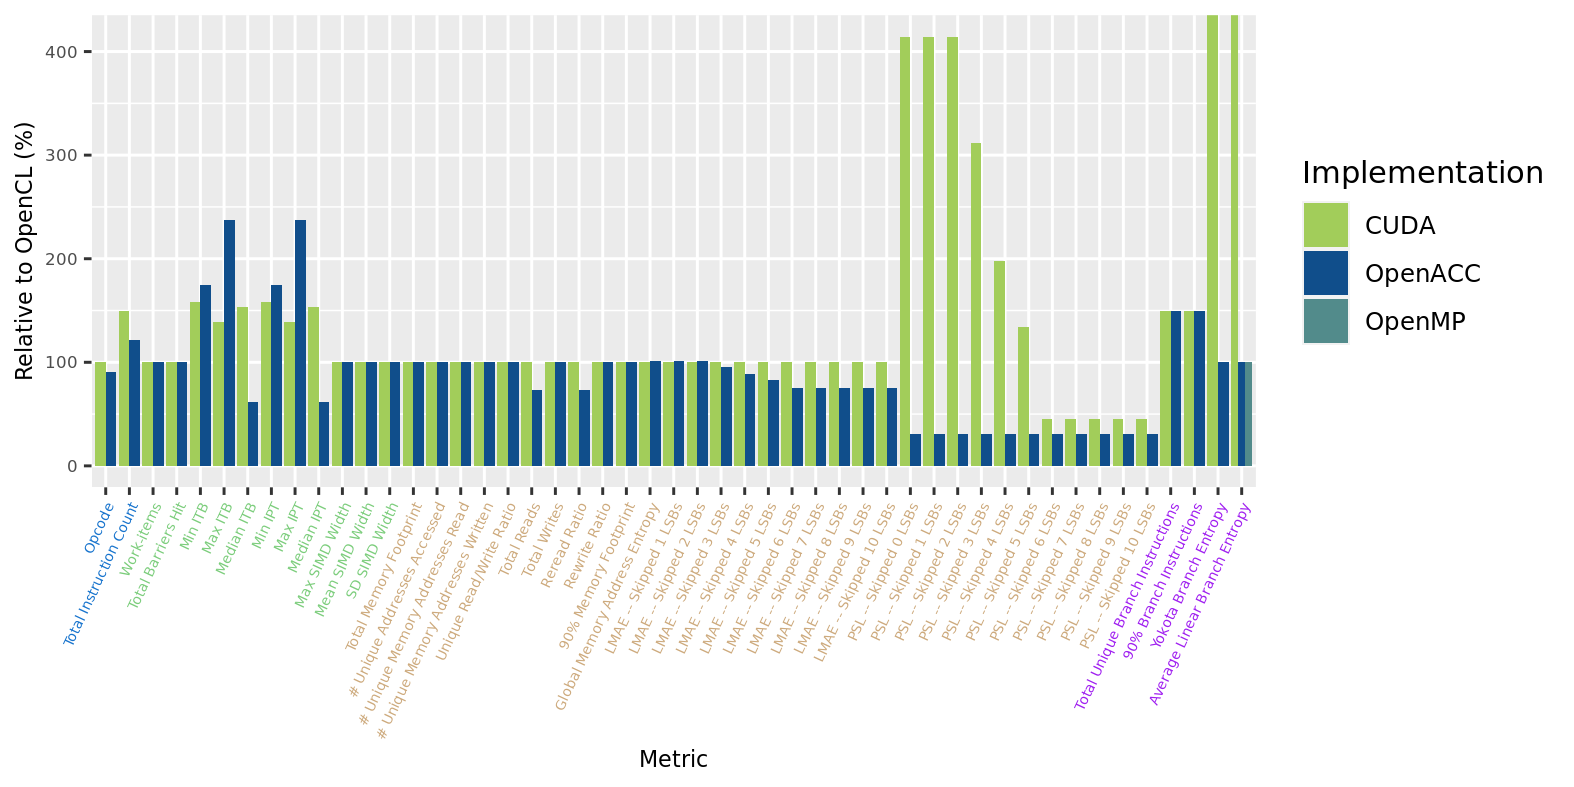

In [35]:
%%R -i fan2_invo0 -w 20 -h 10 --units cm -r 200

is.nan.data.frame <- function(x){
    do.call(cbind, lapply(x, is.nan))
}

#normalize against the OpenCL AIWC metrics...
dat <- data.frame()
for (i in unique(fan2_invo0$metric)){
    cud = fan2_invo0[fan2_invo0$metric == i & fan2_invo0$implementation == 'cuda',]
    ocl = fan2_invo0[fan2_invo0$metric == i & fan2_invo0$implementation == 'opencl',]
    acc = fan2_invo0[fan2_invo0$metric == i & fan2_invo0$implementation == 'openacc',]
    omp = fan2_invo0[fan2_invo0$metric == i & fan2_invo0$implementation == 'openmp',]


    cud$count = cud$count/ocl$count
    acc$count = acc$count/ocl$count
    omp$count = omp$count/ocl$count
    
    dat <- rbind(dat,cud,acc,omp)
}

#some metrics are 0 and divided by zero produce NaNs -- since we want to show that they are both the same when compared to the OpenCL baseline set them to be 1
dat[is.nan(dat)] <- 1

library('ggplot2')
library('broman')
library('patternplot')

# The four categories to assign are: "compute","parallelism","memory","control"
ordered_categories <- dat[dat$implementation=="cuda",]$category
category_colours <- switchv(as.character(ordered_categories), "Parallelism" = "palegreen3", "Compute" = "dodgerblue3", "Memory" = "burlywood3", "Control" = "purple", "red")#red is unknown categories
dat[dat$implementation=="cuda",]$implementation <- "CUDA"
dat[dat$implementation=="openmp",]$implementation <- "OpenMP"
dat[dat$implementation=="openacc",]$implementation <- "OpenACC"

# plot the differences in AIWC metrics
p <- ggplot(data=dat, aes(x=metric,y=(count*100)-100,fill=implementation)) +
        geom_bar(position="dodge",stat = "identity") +
        theme(axis.text.y = element_text(size = 6),
              axis.text.x = element_text(size = 5,hjust = 1,angle=65,colour=category_colours),
              axis.title.x = element_text(size=8),
              axis.title.y = element_text(size=8)) +
        labs(y = "Relative Difference to OpenCL (%)",x="Metric",fill="Implementation")
p <- p + scale_fill_manual(values = c("darkolivegreen3", "dodgerblue4","darkslategray4"))
p <- p + geom_hline(yintercept=0)
print(p)
ggsave("figures/fan2_relative_difference.pdf",p)

p <- ggplot(data=dat, aes(x=metric,y=(count*100),fill=implementation)) +
        geom_bar(position="dodge",stat = "identity") +
        theme(axis.text.y = element_text(size = 6),
              axis.text.x = element_text(size = 5,hjust = 1,angle=65,colour=category_colours),
              axis.title.x = element_text(size=8),
              axis.title.y = element_text(size=8)) +
        labs(y = "Relative to OpenCL (%)",x="Metric",fill="Implementation")
p <- p + scale_fill_manual(values = c("darkolivegreen3", "dodgerblue4","darkslategray4"))
print(p)
ggsave("figures/fan2_relative.pdf",p)

#library(patternplot)
#pattern.type<-c('hdashes', 'vdashes', 'bricks')
#pattern.color=c('black','white', 'grey20')
#background.color=c("darkolivegreen3", "dodgerblue4","darkslategray4")
#density<-c(20, 20, 10)
#barp2<-patternbar(dat,x=dat$metric,y=dat$count*100,group=dat$implementation,ylab="Implementation", pattern.type=pattern.type,hjust=0.5,
#           pattern.color=pattern.color, background.color=background.color,pattern.line.size=c(5.5, 1, 4),
#           frame.color=c('black', 'black', 'black'), density=density)+scale_y_continuous(limits = c(0, 2800))+ggtitle('(B) Colors with Patterns')
#print(barp2)



       metric    category count implementation
3  Work-items Parallelism     1           cuda
63 Work-items Parallelism     1        openacc


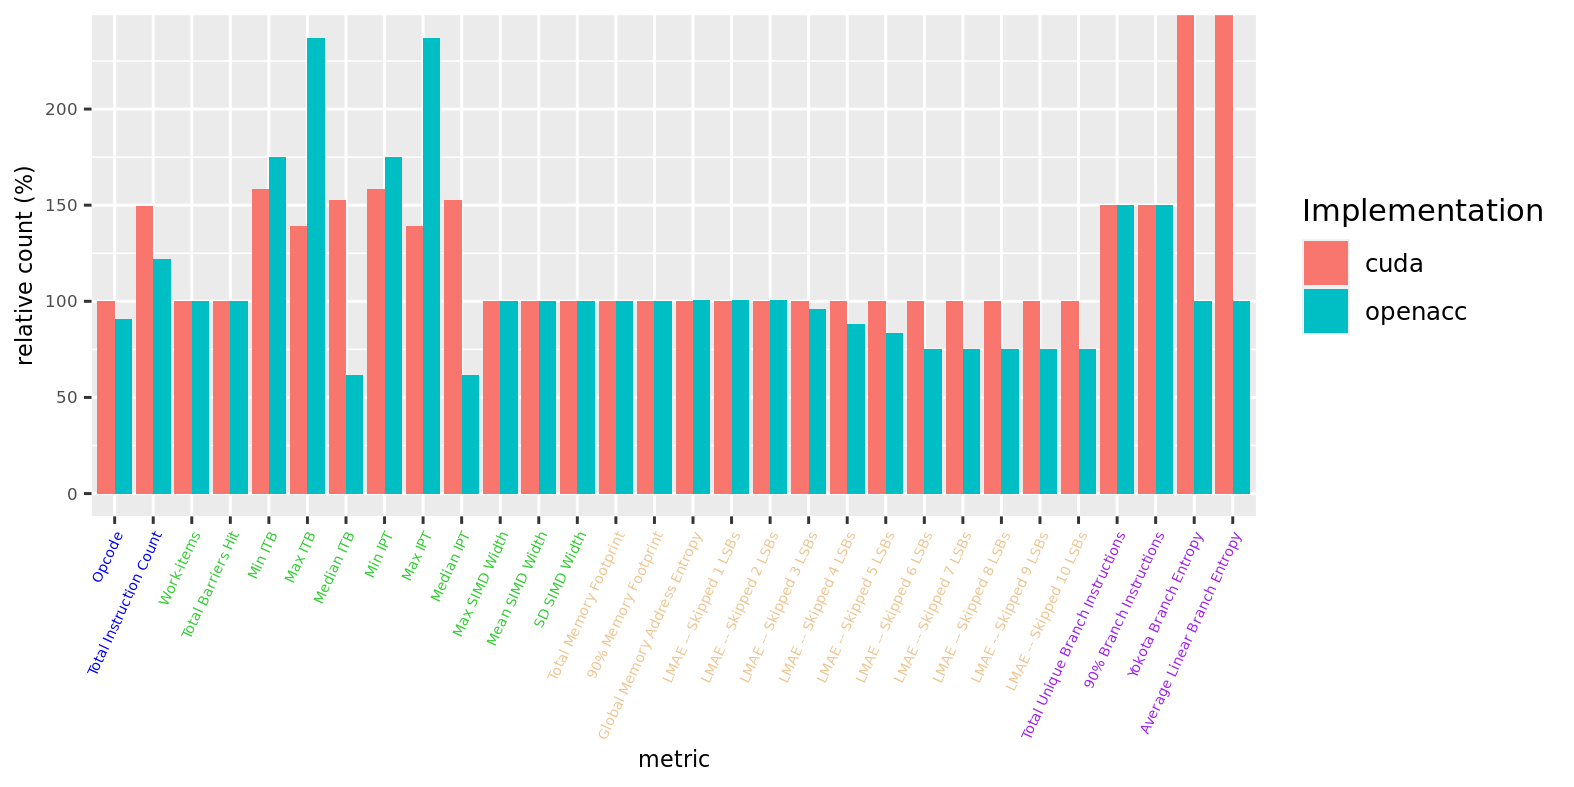

In [372]:
%%R -i fan2_invo0 -w 20 -h 10 --units cm -r 200

is.nan.data.frame <- function(x){
    do.call(cbind, lapply(x, is.nan))
}

#normalize against the OpenCL AIWC metrics...
dat <- data.frame()
for (i in unique(fan2_invo0$metric)){
    cud <- fan2_invo0[fan2_invo0$metric == i & fan2_invo0$implementation == 'cuda',]
    ocl <- fan2_invo0[fan2_invo0$metric == i & fan2_invo0$implementation == 'opencl',]
    acc <- fan2_invo0[fan2_invo0$metric == i & fan2_invo0$implementation == 'openacc',]

    cud$count <- cud$count/ocl$count
    acc$count <- acc$count/ocl$count
    
    dat <- rbind(dat,cud,acc)
}
#some metrics are 0 and divided by zero produce NaNs -- since we want to show that they are both the same when compared to the OpenCL baseline set them to be 1
dat[is.nan(dat)] <- 1

library('ggplot2')
library('broman')
# The four categories to assign are: "compute","parallelism","memory","control"
ordered_categories <- dat[dat$implementation=="cuda",]$category
category_colours <- switchv(as.character(ordered_categories), "Parallelism" = "limegreen", "Compute" = "blue", "Memory" = "burlywood2", "Control" = "purple", "red")#red is unknown categories

# plot the differences in AIWC metrics
p <- ggplot(data=dat, aes(x=metric,y=count*100,fill=implementation)) +
        geom_bar(position="dodge",stat = "identity") +
        theme(axis.text.y = element_text(size = 6),
              axis.text.x = element_text(size = 5,hjust = 1,angle=65,colour=category_colours),
              axis.title.x = element_text(size=8),
              axis.title.y = element_text(size=8)) +
        labs(y = "relative count (%)",x="metric",fill="Implementation")
print(p)
print(dat[dat$metric == "Work-items",])


**TODO:**

* Does the difference in expressing the OpenACC version affect the LMAE entropy scores? For instance, CUDA and OpenCL express parallelism using a 2D work-group whereas OpenACC contains additional logic for the nesting of both `for loops` -- what does this mean for memory accesses and the resultant entropy?
* What about the difference in branch entropies, why is CUDA worse?


# Discussion

**TODO** show/mention that each invocation of the Fan1 and Fan2 kernels change the entropy metrics when run (the accesses are getting more ordered as we operate over a smaller domain), but the other metrics are unchanged.

# Conclusions and Future Work

We show that the Architecture Independent Workload Characterisation methodology can be extended to also be generally language agnostic.
This is demonstrated by taking a OpenCL implementation and comparing it to a CUDA and OpenACC variations of the same task -- all implementations are functionally equivilent with work partitioned to exhibit the same degree/granularity of parallelism.

Language-Agnostic Architecture-Independent Workload Characterization is useful for a range of domains, in scheduling, optimization and node configuration.
With this in mind, the remainer of this work considers future work separated by domain.

Scheduling:

* Most existing HPC codes are written in OpenMP and OpenACC with newer revised editions of scientific codes having a CUDA variation. However OpenCL implementations of these codes are rare. By showing that the statistics around the fundamental computational characteristics of the workload are largely fixed and removed from the language of which it is written, the existing AIWC method can be employed.
* Variations in compiler optimization and toolchain used, the same predictive methodology can be applied to separately trained response-times. (**TODO** add flow-chart figure and a better description.)
* Accurate predictions of a kernels execution time without having to be first primed (measured by empirically running the same kernel over as many devices as are available) (**TODO** finish)

Optimization:

* Some best practices are shared between accelerator architectures and vendors as is shown in the  -- this is our current area of research and is left as future work.
* The presented methodology has promise when we consider FPGAs (**TODO** finish this thought)

Node Configuration:

* Accelerator hardware vendors IP and scientific HPC establishments IP (**TODO** flesh out this thought)

This work has hinted that the methodology in comparing AIWC features-spaces between language implementations can also be used to highlight redundancies/inefficiencies in compiler generated outputs; As was shown when examining the reasons for the difference in absolute branch counts in OpenACC against the CUDA and OpenCL versions.
Perhaps, this could be a useful tool for compiler engineers?

The only other variation of language common to accelerators in scientific HPC is OpenMP.
While currently not included in this work, the next version of OpenARC promises support for OpenMP.
All kernels presented in our work has an OpenMP variatiant ready to go and we will be added in the future.

The justification in selecting the AIWC metrics was that they were believed to measure the essential characteristics of scientific codes removed from, and irrespective of, the given architecture.
It is reassuring that the same rational is true for language implementation; that measurable statistics about a programs properties (such as branching, memory access, etc) capture the essence of the task and that this is true irrespective of both language in which it is expressed and architecture on which it is run.

We plan to apply these AIWC metrics for different language implementations into the Predictive Methodology outlined in [].
This will be used to evaluate the accuracy of these predictions **TODO:**(open thought)

# Extras: Specifics about compiling the codes and running the tests


Additional diagnostic of traces was achieved by adding the following to the `instructionExecuted` function in `Plugins/WorkloadCharacterization.cpp` to oclgrind:
````
  if(workItem->getGlobalID()[0]==0){
     printf("%s ",opcode_name.c_str());
     for (int ops = 0; ops <= instruction->getNumOperands(); ops ++){
         printf("%s ",std::string(instruction->getOperand(ops)->getName().data()).c_str());
     }
     printf("\n");
  }
````

## Compile Cuda code using standard nvidia compiler 

In [2]:
! $NVCC ./gaussian_cuda_version/gaussian.cu -o gaussian_cuda

## Compile OpenCL version of the Cuda code using cocl

In [3]:
! $COCL ./gaussian_cuda_version/gaussian.cu -o gaussian_opencl


Please use: `cocl_py`, which is easier to maintain, and portable

cocl args: ./gaussian_cuda_version/gaussian.cu -o gaussian_opencl
LLVM_COMPILE_FLAGS -I/coriander/coriander/soft/llvm-4.0/include -D_GNU_SOURCE -D__STDC_CONSTANT_MACROS -D__STDC_FORMAT_MACROS -D__STDC_LIMIT_MACROS -I/coriander/coriander/soft/llvm-4.0/include -fPIC -fvisibility-inlines-hidden -Wall -W -Wno-unused-parameter -Wwrite-strings -Wcast-qual -Wmissing-field-initializers -pedantic -Wno-long-long -Wcovered-switch-default -Wnon-virtual-dtor -Wdelete-non-virtual-dtor -Wstring-conversion -Werror=date-time -std=c++11 -ffunction-sections -fdata-sections -fexceptions -D_GNU_SOURCE -D__STDC_CONSTANT_MACROS -D__STDC_FORMAT_MACROS -D__STDC_LIMIT_MACROS
+ /coriander/coriander/soft/llvm-4.0/bin/clang++ -DUSE_CLEW -std=c++11 -x cuda -D__CORIANDERCC__ -D__CUDACC__ --cuda-gpu-arch=sm_30 -nocudalib -nocudainc --cuda-device-only -emit-llvm -O2 -S -Wno-gnu-anonymous-struct -Wno-nested-anon-types -I/coriander/coriander/soft/llvm-4.

## Functionality test of the OpenCL generated version

The code must produce the same results regardless of the compiler and backend before any further evaluation is performed.

In [4]:
! ./gaussian_cuda ./matrix4.txt

Matrix m is: 
    0.00     0.00     0.00     0.00 
    0.50     0.00     0.00     0.00 
    0.67     0.26     0.00     0.00 
   -0.00     0.15    -0.28     0.00 

Matrix a is: 
   -0.60    -0.50     0.70     0.30 
    0.00    -0.65    -0.05     0.55 
   -0.00     0.00    -0.75    -1.14 
    0.00    -0.00     0.00     0.50 

Array b is: 
-0.85 -0.25 0.87 -0.25 

The final solution is: 
0.70 0.00 -0.40 -0.50 


Time total (including memory transfers)	1.115455 sec
Time for CUDA kernels:	0.000068 sec


In [5]:
! ./gaussian_opencl ./matrix4.txt

OpenCL platform: NVIDIA CUDA
OpenCL device: Tesla P100-PCIE-12GB
ignoring cudaDeviceSynchronize for now
ignoring cudaDeviceSynchronize for now
ignoring cudaDeviceSynchronize for now
ignoring cudaDeviceSynchronize for now
ignoring cudaDeviceSynchronize for now
ignoring cudaDeviceSynchronize for now
Matrix m is: 
    0.00     0.00     0.00     0.00 
    0.50     0.00     0.00     0.00 
    0.67     0.26     0.00     0.00 
   -0.00     0.15    -0.28     0.00 

Matrix a is: 
   -0.60    -0.50     0.70     0.30 
    0.00    -0.65    -0.05     0.55 
    0.00    -0.00    -0.75    -1.14 
    0.00    -0.00     0.00     0.50 

Array b is: 
-0.85 -0.25 0.87 -0.25 

The final solution is: 
0.70 -0.00 -0.40 -0.50 


Time total (including memory transfers)	1.504010 sec
Time for CUDA kernels:	0.339834 sec


## Functionality test of the generated vs hand-coded versions

Next, we test for the same functionality against a manually written version.

### Compile the hand-coded version

In [6]:
!cd gaussian_opencl_version/ && g++ gaussianElim.cpp  clutils.cpp utils.cpp -lOpenCL -std=c++11 -o gaussian_hand_opencl && cd ..
!mv gaussian_opencl_version/gaussian_hand_opencl . && cp gaussian_opencl_version/gaussianElim_kernels.cl .

clutils.cpp: In function '_cl_context* cl_init(char)':
clutils.cpp:223:24: warning: '_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)' is deprecated [-Wdeprecated-declarations]
     commandQueueProf = clCreateCommandQueue(context, device, 
                        ^
In file included from clutils.cpp:57:0:
/usr/include/CL/cl.h:1359:1: note: declared here
 clCreateCommandQueue(cl_context                     /* context */,
 ^
clutils.cpp:223:24: warning: '_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)' is deprecated [-Wdeprecated-declarations]
     commandQueueProf = clCreateCommandQueue(context, device, 
                        ^
In file included from clutils.cpp:57:0:
/usr/include/CL/cl.h:1359:1: note: declared here
 clCreateCommandQueue(cl_context                     /* context */,
 ^
clutils.cpp:224:63: warning: '_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_i

In [7]:
! ./gaussian_hand_opencl ./matrix4.txt -p 0 -d 0

Using Platform 0 	 Device No 0 
Creating GPU Context

	gaussianElim_kernels.cl
The result of matrix m is: 
    0.00     0.00     0.00     0.00 
    0.50     0.00     0.00     0.00 
    0.67     0.26     0.00     0.00 
   -0.00     0.15    -0.28     0.00 

The result of matrix a is: 
   -0.60    -0.50     0.70     0.30 
    0.00    -0.65    -0.05     0.55 
    0.00    -0.00    -0.75    -1.14 
    0.00    -0.00     0.00     0.50 

The result of array b is: 
-0.85 -0.25 0.87 -0.25 

The final solution is: 
0.70 -0.00 -0.40 -0.50 



## AIWC feature-space comparison between the generated and hand-coded version

Here they should be similar enough to show that AIWC and it's OpenCL back-end is suitable for language agnostic architecture-independent workload characterization

In [10]:
! $OCLGRIND_BIN --aiwc ./gaussian_hand_opencl matrix4.txt -p 0 -d 0

Using Platform 0 	 Device No 0 
This Context Type Not Supported
: Success
	gaussianElim_kernels.cl
Architecture-Independent Workload Characterization of kernel: Fan1
+----------------------------------------------------------------------------+
|Compute Opcode Instruction Histogram                                        |
+============================================================================+
instruction: getelementptr count: 18
instruction: load count: 6
instruction: br count: 7
instruction: sext count: 9
instruction: call count: 4
instruction: add count: 10
instruction: trunc count: 4
instruction: store count: 3
instruction: icmp count: 4
instruction: mul count: 6
instruction: ret count: 4
instruction: sub count: 4
instruction: fdiv count: 3
+----------------------------------------------------------------------------+
|Compute Opcode Unique Opcodes required to cover 90% of Dynamic Instructions |
+============================================================================+
Un

In [12]:
! $OCLGRIND_BIN --aiwc ./gaussian_opencl ./matrix4.txt

OpenCL platform: Oclgrind
OpenCL device: Oclgrind Simulator
Architecture-Independent Workload Characterization of kernel: _Z4Fan1PfS_ii
+----------------------------------------------------------------------------+
|Compute Opcode Instruction Histogram                                        |
+============================================================================+
instruction: sub count: 512
instruction: bitcast count: 515
instruction: icmp count: 512
instruction: mul count: 518
instruction: trunc count: 1536
instruction: store count: 3
instruction: fdiv count: 3
instruction: ret count: 512
instruction: add count: 1030
instruction: br count: 515
instruction: load count: 6
instruction: getelementptr count: 533
instruction: call count: 1536
instruction: sext count: 9
+----------------------------------------------------------------------------+
|Compute Opcode Unique Opcodes required to cover 90% of Dynamic Instructions |
+===========================================================

Architecture-Independent Workload Characterization of kernel: _Z4Fan1PfS_ii
+----------------------------------------------------------------------------+
|Compute Opcode Instruction Histogram                                        |
+============================================================================+
instruction: sub count: 512
instruction: bitcast count: 513
instruction: icmp count: 512
instruction: mul count: 514
instruction: sext count: 3
instruction: call count: 1536
instruction: getelementptr count: 519
instruction: load count: 2
instruction: br count: 513
instruction: add count: 1026
instruction: trunc count: 1536
instruction: fdiv count: 1
instruction: store count: 1
instruction: ret count: 512
+----------------------------------------------------------------------------+
|Compute Opcode Unique Opcodes required to cover 90% of Dynamic Instructions |
+============================================================================+
Unique Op Codes comprising of 90% of dyna

## OpenARC Usage and Setup

<a id='openarc-usage-and-setup'></a>

We used two separate versions of OpenARC in this evaluation, a publicly available version which supports OpenACC and a currently-private facing version which supports OpenMP.
If you wish to reproduce our work you -- please request access from [Seeyong Lee](lees2@ornl.gov).

Each version has a number of build steps before this Jupyter artifact can be run.
In our evaluation we are using Docker.
In a running docker instance (see [the readme](../README.md) for Docker details), clone each of the two versions in the /workspace/codes directory -- ours are placed in /workspace/codes/openarc-openacc and /workspace/codes/openarc-openmp directories respective to the openacc and openmp versions.

Each version requires a binary for translation and a runtime library to be built, this is achieved by `cd`ing into each versions directory and running `OPENARC_ARCH=1 ACC_DEVICE_TYPE=RADEON ./build.sh bin` to build the binary, then `cd` into the versions `openarcrt` subdirectory and run `batchmake.bash` -- e.g. `root@machine/workspace/codes/openarc-openmp/openarcrt# ./batchmake.bash`.


### Test with textures

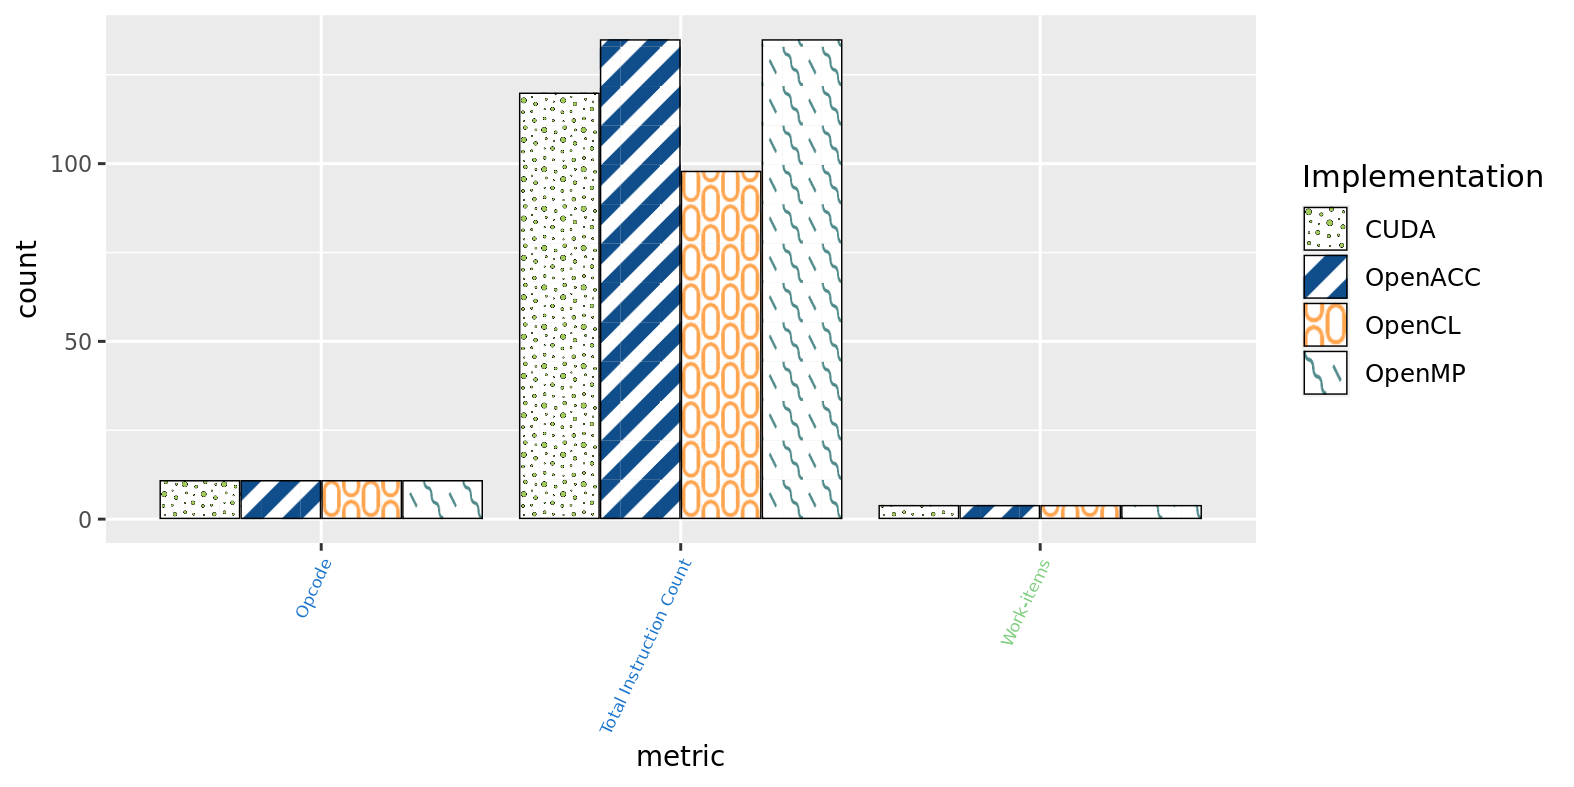

In [99]:
%%R -i fan1_invo0 -w 20 -h 10 --units cm -r 200

library('ggplot2')
library(broman)
library(ggtextures)
library(grid)
library(magick)

dat <- fan1_invo0
ordered_categories <- dat[dat$implementation=="cuda",]$category

dat[dat$implementation=="cuda",]$implementation <- "CUDA"
dat[dat$implementation=="openmp",]$implementation <- "OpenMP"
dat[dat$implementation=="openacc",]$implementation <- "OpenACC"
dat[dat$implementation=="opencl",]$implementation <- "OpenCL"

# The four categories to assign are: "Compute","Parallelism","Memory","Control"
category_colours <- switchv(as.character(ordered_categories), "Parallelism" = "palegreen3", "Compute" = "dodgerblue3", "Memory" = "burlywood3", "Control" = "purple", "red")#red is unknown categories
#print(category_colours)

images = c(
  CUDA = "./plot-assets/cuda-bubbles.svg",
  OpenMP = "./plot-assets/openmp-wiggle.svg",
  OpenACC = "./plot-assets/openacc-diagonal-stripes.svg",
  OpenCL = "./plot-assets/opencl-cage.svg"
)
#for testing just discard all but 2 metrics
dat <- dat[dat$metric=="Opcode" | dat$metric=="Work-items" | dat$metric=="Total Instruction Count",]

p <- ggplot(data=dat, aes(x=metric,y=count,image=implementation)) +
        geom_textured_bar(position="dodge", stat = "identity",img_width = unit(0.5, "cm")) +
        theme(axis.text.y = element_text(size = 8),
              axis.text.x = element_text(size=6, hjust = 1,angle=65, colour=category_colours),
              axis.title.x = element_text(size=10),
              axis.title.y = element_text(size=10))
p <- p + scale_image_manual(values = images,"Implementation")
#p <- p + scale_fill_manual(values = c("darkolivegreen3", "dodgerblue4", "tan1","darkslategray4"),"Implementation")
print(p)